# **1 - Imports**

In [59]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetB4, ResNet152V2
from tensorflow.keras.layers import GlobalAvgPool2D, Dense, Activation,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## **2 - Data Distribution**

In [3]:
dataset_path = '../input/weather-dataset/dataset'
class_names = sorted(os.listdir(dataset_path))
class_count = len(class_names)
class_dist = [len(os.listdir(dataset_path + "/" + name)) for name in class_names]
print(class_count)
class_dist

11


[698, 851, 475, 639, 591, 377, 526, 232, 1160, 692, 621]

In [4]:
fig = px.pie(names=class_names, values=class_dist, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

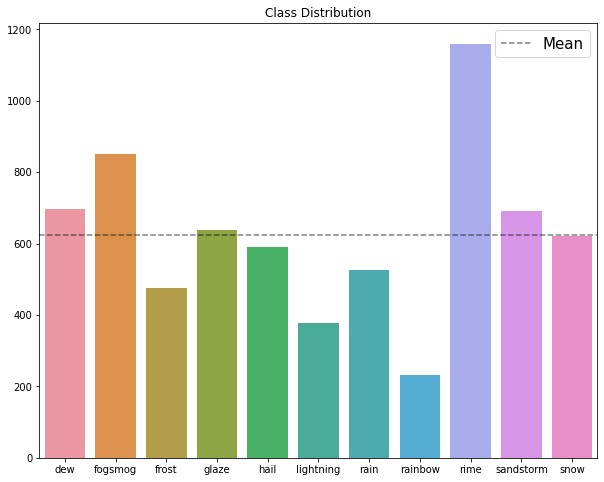

In [5]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dist
)
plt.axhline(np.mean(class_dist), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

## **3 - Data Preprocessing**

In [6]:
def createDataFrame(path):
    # create a dataframe : filepath | label
    filepaths = []
    labels = []    
    classlist = os.listdir(path)
    for klass in classlist:
        classpath = os.path.join(path,klass)
        filelists = os.listdir(classpath)
        for f in filelists:
            filepath=os.path.join(classpath,f)
            filepaths.append(filepath)
            labels.append(klass)
    filepaths_df =pd.Series(filepaths, name='filepath')
    labels_df = pd.Series(labels, name='label')
    df=pd.concat([filepaths_df, labels_df], axis=1) 
    return df

In [7]:
df = createDataFrame(dataset_path)
df

,filepath,label
0,../input/weather-dataset/dataset/hail/0106.jpg,hail
1,../input/weather-dataset/dataset/hail/0375.jpg,hail
2,../input/weather-dataset/dataset/hail/0285.jpg,hail
3,../input/weather-dataset/dataset/hail/0074.jpg,hail
4,../input/weather-dataset/dataset/hail/0077.jpg,hail
...,...,...
6857,../input/weather-dataset/dataset/dew/2689.jpg,dew
6858,../input/weather-dataset/dataset/dew/2607.jpg,dew
6859,../input/weather-dataset/dataset/dew/2691.jpg,dew
6860,../input/weather-dataset/dataset/dew/2867.jpg,dew


In [8]:
def splitDataFrame (df, trsplit, vsplit, random_seed):
    # split df into train_df, valid_df and test_df
    dsplit=vsplit/(1-trsplit)
    strat=df['label']    
    train_df, dummy_df=train_test_split(df, train_size=trsplit, shuffle=True, random_state=random_seed, stratify=strat)
    strat=dummy_df['label']
    valid_df, test_df=train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=random_seed, stratify=strat)
    print('train_df : ', len(train_df), ' | valid_df : ', len(valid_df), ' | test_df : ',len(test_df))              
    return train_df, valid_df, test_df

In [9]:
train_df, valid_df, test_df = splitDataFrame(df, .8,.1, 123)
train_df

train_df :  5489  | valid_df :  686  | test_df :  687


,filepath,label
957,../input/weather-dataset/dataset/frost/3777.jpg,frost
5000,../input/weather-dataset/dataset/glaze/6388.jpg,glaze
2856,../input/weather-dataset/dataset/fogsmog/4536.jpg,fogsmog
6036,../input/weather-dataset/dataset/sandstorm/321...,sandstorm
3305,../input/weather-dataset/dataset/fogsmog/4678.jpg,fogsmog
...,...,...
3843,../input/weather-dataset/dataset/snow/1356.jpg,snow
1871,../input/weather-dataset/dataset/rime/6048.jpg,rime
2031,../input/weather-dataset/dataset/rime/4931.jpg,rime
2382,../input/weather-dataset/dataset/rime/6080.jpg,rime


In [10]:
trcount=len(train_df['label'].unique())
vcount=len(valid_df['label'].unique())
tecount=len(test_df['label'].unique())
print("train classes : ", trcount)
print("valid classes : ", vcount)
print("test classes : ", tecount)

train classes :  11
valid classes :  11
test classes :  11


In [11]:
groups = train_df.groupby('label')
for label in train_df['label'].unique():
    group = groups.get_group(label)
    print(label, " : ", len(group))

frost  :  380
glaze  :  511
fogsmog  :  681
sandstorm  :  553
rime  :  928
lightning  :  301
hail  :  473
rain  :  421
dew  :  558
snow  :  497
rainbow  :  186


In [12]:
def trim (df, max_size, min_size, column):
    df = df.copy()
    original_class_count = len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list = [] 
    groups = df.groupby(column)
    for label in df[column].unique():        
        group = groups.get_group(label)
        sample_count = len(group)         
        if sample_count > max_size :
            strat = group[column]
            samples,_ = train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count >= min_size:
            sample_list.append(group)
    df = pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count = len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance = list(df[column].value_counts())
    print(balance)
    return df

In [13]:
def balance(train_df,max_samples, min_samples, column, working_dir, image_size):
    train_df=train_df.copy()
    train_df=trim (train_df, max_samples, min_samples, column)    
    # make directories to store augmented images
    aug_dir=os.path.join(working_dir, 'aug')
    if os.path.isdir(aug_dir):
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)
    for label in train_df['label'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path)
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=train_df.groupby('label') # group by class
    
    for label in train_df['label'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class
        if sample_count< max_samples: # if the class has less than target number of images
            aug_img_count=0
            delta=max_samples-sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images    
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepath', y_col=None, target_size=image_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
        print('Total Augmented images created = ', total)
        # create aug_df and merge with train_df to create composite training set ndf
        if total>0:
            aug_fpaths=[]
            aug_labels=[]
            classlist=os.listdir(aug_dir)
            for klass in classlist:
                classpath=os.path.join(aug_dir, klass)     
                flist=os.listdir(classpath)    
                for f in flist:        
                    fpath=os.path.join(classpath,f)         
                    aug_fpaths.append(fpath)
                    aug_labels.append(klass)
            Fseries=pd.Series(aug_fpaths, name='filepath')
            Lseries=pd.Series(aug_labels, name='label')
            aug_df=pd.concat([Fseries, Lseries], axis=1)
            train_df=pd.concat([train_df,aug_df], axis=0).reset_index(drop=True)
            print (list(train_df['label'].value_counts()) )
    return train_df
    

In [14]:
channels=3
batch_size=20
img_size=(256,256)
img_shape=(img_size[0], img_size[1], channels)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img/255  
trgen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
tvgen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=trgen.flow_from_dataframe( train_df, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe( test_df, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)

valid_gen=tvgen.flow_from_dataframe( valid_df, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=int(np.ceil(len(train_gen.labels)/batch_size))

test batch size:  3   test steps:  229
Found 5489 validated image filenames belonging to 11 classes.
Found 687 validated image filenames belonging to 11 classes.
Found 686 validated image filenames belonging to 11 classes.


In [15]:
train_dict=train_gen.class_indices
classes=list(train_dict.keys()) 
train_dict

{'dew': 0,
 'fogsmog': 1,
 'frost': 2,
 'glaze': 3,
 'hail': 4,
 'lightning': 5,
 'rain': 6,
 'rainbow': 7,
 'rime': 8,
 'sandstorm': 9,
 'snow': 10}

## **4 - Data Visualisation**

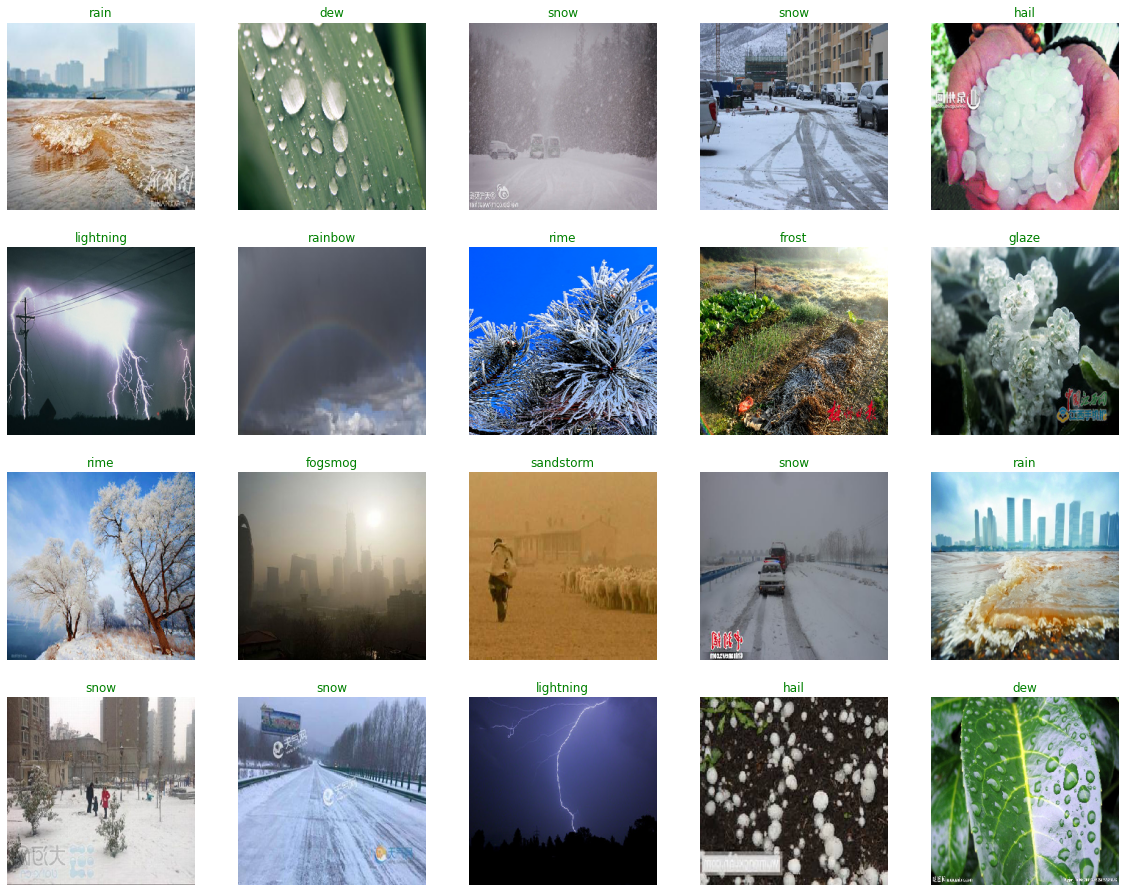

In [19]:
images,labels=next(train_gen)

plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    image=images[i]
    plt.imshow(image)
    index=np.argmax(labels[i])
    class_name=classes[index]
    plt.title(class_name, color='green', fontsize=12)
    plt.axis('off')
plt.show()

## **5- ResNet152V2 Model**

In [20]:
resnet_base_model = ResNet152V2(include_top=False, input_shape=img_shape)
resnet_base_model.trainable = False

resnet_model = Sequential([
    resnet_base_model,
    GlobalAvgPool2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(class_count, activation="softmax")
])

resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [21]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("resnet.h5", save_best_only=True)
]
resnet_model.fit(x=train_gen, epochs=20, callbacks=callbacks, validation_data=valid_gen)

Epoch 1/20
275/275 [==============================] - 64s 206ms/step - loss: 0.8772 - accuracy: 0.7149 - val_loss: 0.4322 - val_accuracy: 0.8528
Epoch 2/20
275/275 [==============================] - 53s 194ms/step - loss: 0.5040 - accuracy: 0.8295 - val_loss: 0.3556 - val_accuracy: 0.8848
Epoch 3/20
275/275 [==============================] - 54s 195ms/step - loss: 0.3816 - accuracy: 0.8714 - val_loss: 0.3467 - val_accuracy: 0.8805
Epoch 4/20
275/275 [==============================] - 55s 198ms/step - loss: 0.3121 - accuracy: 0.8918 - val_loss: 0.3370 - val_accuracy: 0.8892
Epoch 5/20
275/275 [==============================] - 54s 197ms/step - loss: 0.2772 - accuracy: 0.9071 - val_loss: 0.3024 - val_accuracy: 0.9009
Epoch 6/20
275/275 [==============================] - 53s 194ms/step - loss: 0.2490 - accuracy: 0.9160 - val_loss: 0.3154 - val_accuracy: 0.9155
Epoch 7/20
275/275 [==============================] - 54s 196ms/step - loss: 0.2131 - accuracy: 0.9275 - val_loss: 0.3326 - val_ac

In [57]:
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames 
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    errors=0      
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)         
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors=errors + 1
        y_pred.append(pred_index) 
        
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():        
            count=error_indices.count(key) 
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class 
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

229/229 [==============================] - 9s 40ms/step


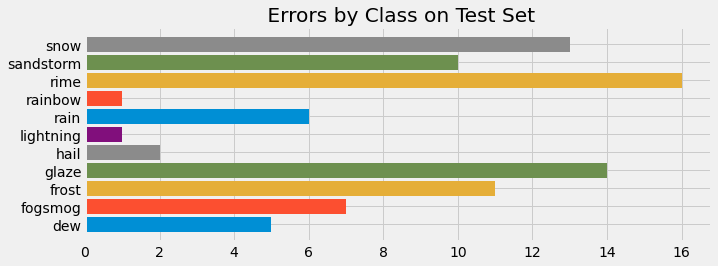

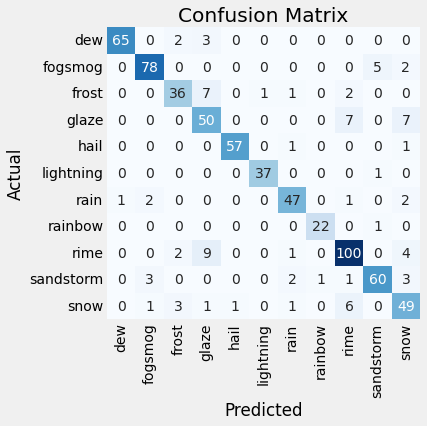

Classification Report:
----------------------
               precision    recall  f1-score   support

         dew       0.98      0.93      0.96        70
     fogsmog       0.93      0.92      0.92        85
       frost       0.84      0.77      0.80        47
       glaze       0.71      0.78      0.75        64
        hail       0.98      0.97      0.97        59
   lightning       0.97      0.97      0.97        38
        rain       0.89      0.89      0.89        53
     rainbow       0.96      0.96      0.96        23
        rime       0.85      0.86      0.86       116
   sandstorm       0.90      0.86      0.88        70
        snow       0.72      0.79      0.75        62

    accuracy                           0.87       687
   macro avg       0.89      0.88      0.88       687
weighted avg       0.88      0.87      0.88       687



In [61]:
print_code=0
subject = 'weather'
preds=resnet_model.predict(test_gen, steps=test_steps, verbose=1) 
print_info( test_gen, preds, print_code, dataset_path, subject)  

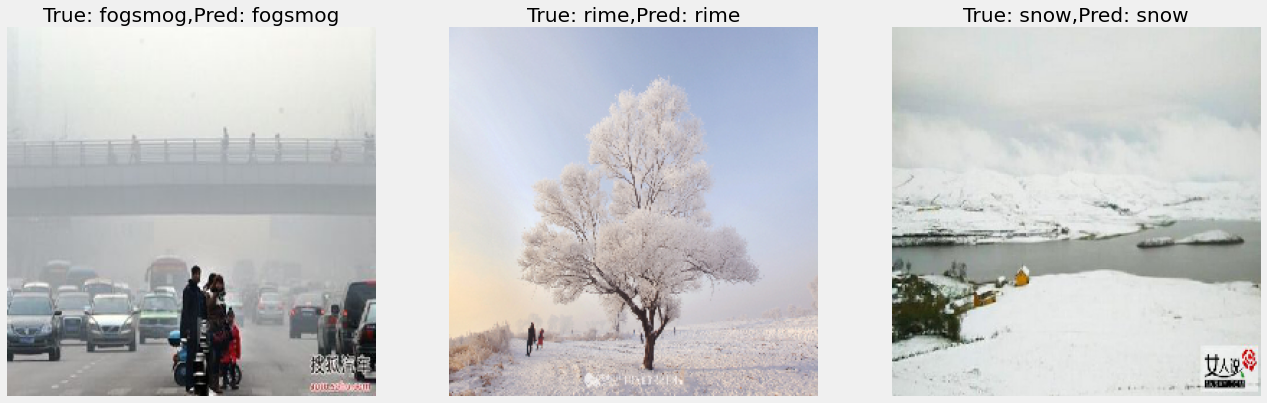

In [64]:
images,labels=next(test_gen)
pred = resnet_model.predict(images)
p=[np.argmax(pred[i]) for i in range(pred.shape[0])]

plt.figure(figsize=(20, 20))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    image=images[i]
    plt.imshow(image)
    index=np.argmax(labels[i])
    pred_label=class_names[p[i]]
    true_label=class_names[index]
    plt.title(f"True: {true_label},Pred: {pred_label}")
    plt.axis('off')
plt.show()